# Face to Emoji (CS445 Course Project)

In [1]:
import os
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

## Parameters

In [2]:
# training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
LEARNING_RATE = 1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# path parameters
DATA_PATH = './data'
WEIGHTS_PATH = "./weights/resnet18_affectnet.pth"
EMOJI_PATH = "./emoji"

# EMOJI parameters
NUM_EMOJI = 8
EMOJI_TYPES = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

## Data

In [3]:
# Load ImageNette dataset
img_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))]
)
data_set = datasets.ImageFolder(root="./data/AffectNet", transform=img_transform)
train_set, test_set = torch.utils.data.random_split(data_set, [int(0.8*len(data_set)), len(data_set)-int(0.8*len(data_set))])

train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

## Motify model

In [4]:
pipeline = models.resnet18(pretrained=True)
num_ftrs = pipeline.fc.in_features
pipeline.fc = nn.Linear(num_ftrs, NUM_EMOJI)
pipeline = pipeline.to(device)

## Training

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pipeline.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [7]:
for epoch in tqdm(range(NUM_EPOCHS)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = pipeline(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

    # Save model every 10 epoches
    if epoch % 10 == 9:
        torch.save(pipeline.state_dict(), WEIGHTS_PATH)

print('Finished Training')



## Save model

In [ ]:
torch.save(pipeline.state_dict(), WEIGHTS_PATH)

## Load model

In [9]:
pipeline = models.resnet18(pretrained=True)
num_ftrs = pipeline.fc.in_features
pipeline.fc = nn.Linear(num_ftrs, NUM_EMOJI)
pipeline = pipeline.to(device)

pipeline.load_state_dict(torch.load(WEIGHTS_PATH, map_location=torch.device('cpu')))
pipeline.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## test

In [10]:
correct = 0
total = 0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # predict
    outputs = pipeline(inputs).detach()
    preds = np.argmax(outputs, axis=1)
    for j in range(len(preds)):
        total += 1
        if labels[j] == preds[j]:
            correct += 1
print("accuracy: ", correct / total)

accuracy:  0.9313548387096774


## Face detection in a image

To Sirui: 你跑的时候可以直接从这里开始跑

In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

In [2]:
import random
from PIL import Image, ImageDraw
from skimage.draw import disk
from facenet_pytorch import MTCNN, InceptionResnetV1

In [3]:
# training parameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# path parameters
WEIGHTS_PATH = "./weights/resnet18_affectnet.pth"
EMOJI_PATH = "./emoji"

# EMOJI parameters
# NUM_EMOJI = 7
NUM_EMOJI = 8
# EMOJI_TYPES = ["anger", "contempt", "disgust", "fear", "happy", "sad", "surprise"]
EMOJI_TYPES = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [4]:
def prepare_model():
    # Emotion Prediction
    pipeline = models.resnet18(pretrained=True)
    num_ftrs = pipeline.fc.in_features
    pipeline.fc = nn.Linear(num_ftrs, NUM_EMOJI)
    emotion_model = pipeline.to(device)

    emotion_model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=torch.device('cpu')))
    emotion_model.eval()
    
    # Face Detection
    mtcnn = MTCNN(keep_all=True, device=device)
    
    return emotion_model, mtcnn
    
def prepare_emoji():
    emoji_images = {}
    for emo in EMOJI_TYPES:
        emoji_images[emo] = []
        emoji_images_path = os.path.join(EMOJI_PATH, emo)
        for img in os.listdir(emoji_images_path):
            if ".png" in img:
                emoji = cv2.imread(os.path.join(emoji_images_path, img))
                emoji = np.where(emoji!=np.array([76, 112, 71]), emoji, np.zeros(3)).astype(np.uint8)
                emoji_images[emo].append(emoji)
        
    return emoji_images

In [5]:
# We use models and emoji images as global variables
emotion_predictor, face_detector = prepare_model()
emoji_images = prepare_emoji()

In [6]:
class Face2emoji:
    """
        This class contains the pipeline of detecting faces, predicting emotions and pasting emojis onto the image.
        When precess a new image, use reset() or create a new Face2emoji class.
    """
    def __init__(self, image):
        self.image = image
        self.boxes = []
        self.faces = []
        self.emotions = []
        self.centers = []
        self.sizes = []
        self.toTensor = transforms.ToTensor()

    def reset(self, image):
        self.image = image
        self.boxes = []
        self.faces = []
        self.emotions = []
        self.centers = []
        self.sizes = []

    def _detect_faces(self):
        # Detect faces
        self.boxes, _ = face_detector.detect(self.image)
        
    def draw_faces(self):
        # Draw faces
        # For visualization
        img_draw = self.image.copy()
        draw = ImageDraw.Draw(img_draw)
        for box in self.boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        display(img_draw)
    
    def _get_faces(self):
        # Get images which each of them only contain a single face
        # The output will be used for emotion prediction
        for box in self.boxes:
            face = self.image.crop(box)
            self.faces.append(face)

    def _predict_emotions(self):
        # Use pretrained network to predict emotion
        # Current network pipeline: Pretrained ResNet18
        for face in self.faces:
            emo_prob = emotion_predictor(self.toTensor(face).unsqueeze(0)).detach().numpy()
            emo = np.argmax(emo_prob)
            self.emotions.append(EMOJI_TYPES[emo])
    
    def _get_centers_and_sizes(self):
        # Centers: Let us know where we should paste the emoji image
        # Size: Let use know how big we should resize the emoji image so that it can cover the whole original face
        for box in self.boxes:
            self.centers.append(((box[0]+box[2])/2, (box[1]+box[3])/2))
            self.sizes.append(max(box[2]-box[0], box[3]-box[1]))
            
    def _get_random_emoji_image(self, emo):
        # For diversity, we put multiple emoji images in one emotion folder
        # Randonly pick one when we use it
        return random.choice(emoji_images[emo])

    def _paste_emoji(self):
        # Paste the emoji image onto the original image. And display it
        out_image = self.image.copy()
        for i in range(len(self.emotions)):
            emoji_image = self._get_random_emoji_image(self.emotions[i])
            emoji_image = cv2.resize(emoji_image, (int(self.sizes[i]), int(self.sizes[i])))
            # Generate a mask to remove the edge of emoji
            emoji_gray = cv2.cvtColor(emoji_image, cv2.COLOR_BGR2GRAY)
            mask_ = np.ones_like(emoji_gray)*255
            mask_ = np.where(emoji_gray!=0, mask_, 0).astype(np.uint8)
#             mask_ = np.mean(mask_, axis=-1)
#             emoji_image = Image.fromarray(emoji_image[:,:,::-1])
#             emoji_size = emoji_image.size
#             radius = max(emoji_size) / 2
#             mask = np.zeros(emoji_size, dtype=np.uint8)
#             rr, cc = disk((radius, radius), 0.85*radius)
#             mask[rr, cc] = 255
#             mask_ = mask
            emoji_image = Image.fromarray(emoji_image[:,:,::-1])
            mask_ = Image.fromarray(mask_)
            # Upper-left of the emoji
            paste_position = [int(self.centers[i][0]-emoji_image.size[0]/2),
                              int(self.centers[i][1]-emoji_image.size[1]/2)]
            out_image.paste(im=emoji_image, box=paste_position, mask=mask_)
#         out_image = np.array(out_image)
#         out_image = cv2.medianBlur(out_image,5)
#         out_image = Image.fromarray(out_image)
            
        display(out_image)
 
    def run(self):
        # Use to run the whole experiment
        self._detect_faces()
        self._get_faces()
        self._get_centers_and_sizes()
        self._predict_emotions()
        self._paste_emoji()
        


## Run experiment

In [7]:
exp = Face2emoji(Image.open("./img/test.png"))

/Users/lvweijie/opt/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


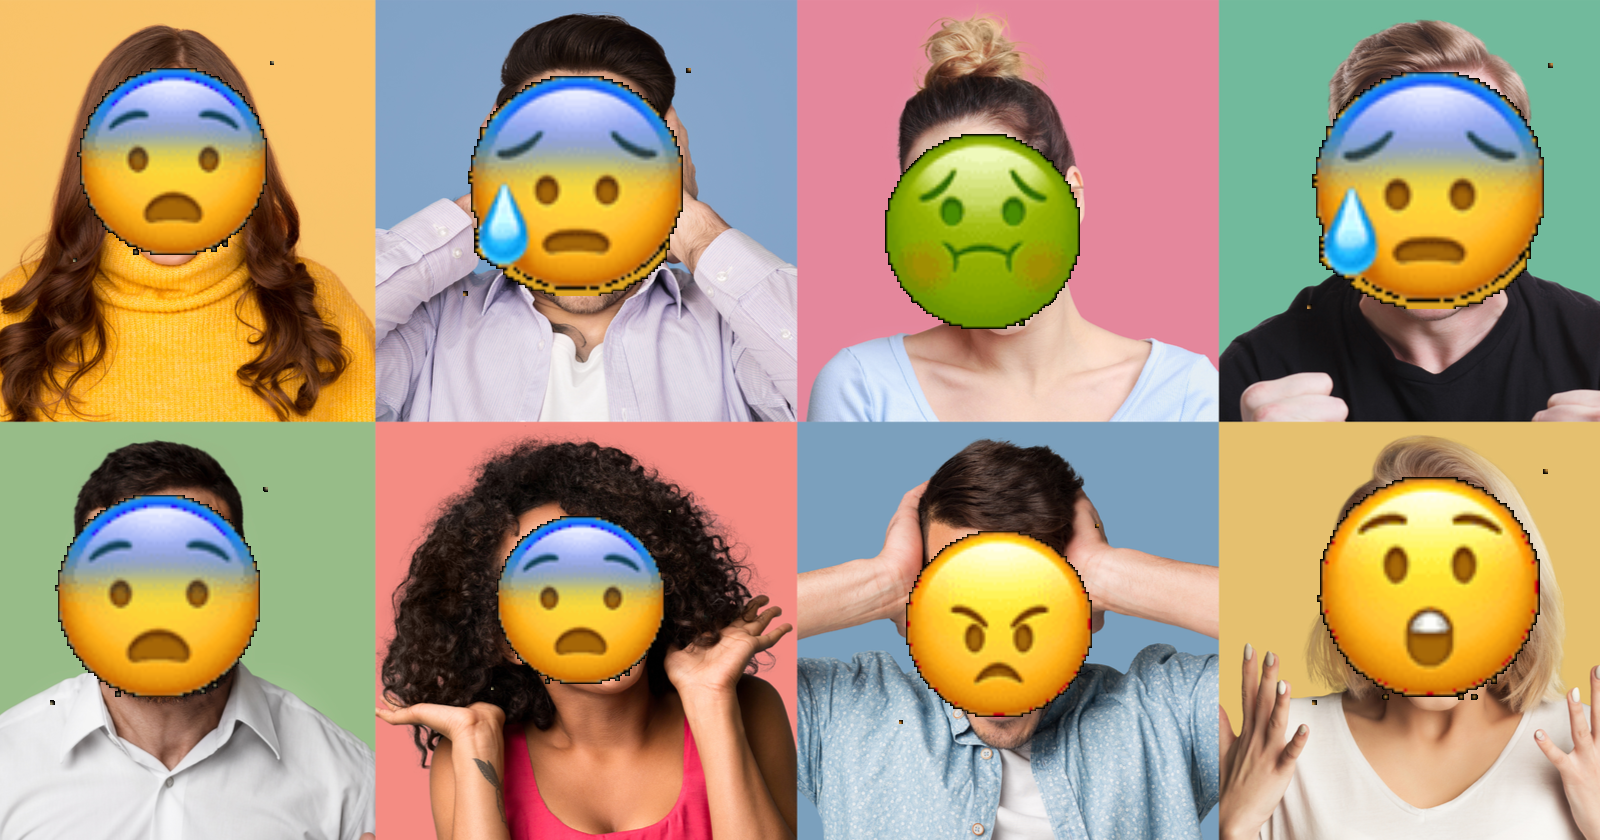

In [8]:
out = exp.run()

## Beyond Face2emoji

### Emoji orientation 

Reference :

    https://pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
    
    https://www.linuxtut.com/en/1e68a7572bc5736d474e/

In [9]:
import cv2
import dlib
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [10]:
predictor_path = "./weights/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector() # Call the face detector. Only the face is detected.
predictor = dlib.shape_predictor(predictor_path) # Output landmarks such as eyes and nose from the face

In [64]:
def get_rotation_matrix(angles):
    a, b, y = angles
    R = np.array([
        [np.cos(a)*np.cos(b), np.cos(a)*np.sin(b)*np.sin(y)-np.sin(a)*np.cos(y), np.cos(a)*np.sin(b)*np.cos(y)+np.sin(a)*np.sin(y)],
        [np.sin(a)*np.cos(b), np.sin(a)*np.sin(b)*np.sin(y)+np.cos(a)*np.cos(y), np.sin(a)*np.sin(b)*np.cos(y)-np.cos(a)*np.sin(y)],
        [-np.sin(b), np.cos(b)*np.sin(y), np.cos(b)*np.cos(y)]
    ])
    return R

def coord_transform(img, R):
    new_img = np.zeros_like(img)
    h, w, _ = img.shape
    r = max(h, w)/2
    for i in range(h):
        for j in range(w):
            original_coord = np.array([0, r-i, j-r])
            new_coord = np.dot(R, original_coord)
            new_x = min(int(new_coord[2] + r), w-1)
            new_y = min(int(r - new_coord[1]), h-1)
            new_img[new_y][new_x] = img[i][j].copy()
#             original_coord = np.array([j-r, r-i, 0])
#             new_coord = np.dot(R, original_coord)
#             new_x = min(int(new_coord[0] + r), w-1)
#             new_y = min(int(r - new_coord[1]), h-1)
#             new_img[new_y][new_x] = img[i][j].copy()
        
    return new_img

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

In [65]:
model_points = np.array([
    (0.0,0.0,0.0), # 30
    (-30.0,-125.0,-30.0), # 21
    (30.0,-125.0,-30.0), # 22
    (-60.0,-70.0,-60.0), # 39
    (60.0,-70.0,-60.0), # 42
    (-40.0,40.0,-50.0), # 31
    (40.0,40.0,-50.0), # 35
    (-70.0,130.0,-100.0), # 48
    (70.0,130.0,-100.0), # 54
    (0.0,158.0,-10.0), # 57
    (0.0,250.0,-50.0) # 8
])

In [84]:
class RotatedFace2emoji(Face2emoji):
    def __init__(self, image):
        super(RotatedFace2emoji, self).__init__(image)
        self.rotations = []
        
    def reset(self, image):
        super(RotatedFace2emoji, self).reset(image)
        self.rotations = []

    def _detect_rotation(self):
        for i in range(len(self.faces)):
#             display(self.faces[i])
            gray = cv2.cvtColor(np.array(self.faces[i]), cv2.COLOR_BGR2GRAY)
            rects = detector(gray, 0) #Detect face from gray
            shape = predictor(gray, rects[0])
            shape = shape_to_np(shape)
            
            for (x, y) in shape: #Plot 68 landmarks on the entire face                
                image_points = np.array([
                    tuple(shape[30]),#Nose tip
                    tuple(shape[21]),
                    tuple(shape[22]),
                    tuple(shape[39]),
                    tuple(shape[42]),
                    tuple(shape[31]),
                    tuple(shape[35]),
                    tuple(shape[48]),
                    tuple(shape[54]),
                    tuple(shape[57]),
                    tuple(shape[8]),
                ],dtype='double')
            
            image_size = self.image.size
            focal_length = image_size[1]
            center = (image_size[1] // 2, image_size[0] // 2) #Face center coordinates

            camera_matrix = np.array([
                [focal_length, 0, center[0]],
                [0, focal_length, center[1]],
                [0, 0, 1]
            ], dtype='double')

            dist_coeffs = np.zeros((4, 1))

            (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix,
                                                                          dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
            #Rotation matrix and Jacobian
            (rotation_matrix, jacobian) = cv2.Rodrigues(rotation_vector)
            mat = np.hstack((rotation_matrix, translation_vector))

            #yaw,pitch,Take out roll
            (_, _, _, _, _, _, eulerAngles) = cv2.decomposeProjectionMatrix(mat)
            yaw = eulerAngles[1][0] /180*np.pi
            pitch = eulerAngles[0][0] /180*np.pi 
            roll = eulerAngles[2][0] /180*np.pi
            if roll > 1.5:
                roll = roll - np.pi
            self.rotations.append([yaw, pitch, roll])
#             print(yaw, pitch, roll)
            
    def _paste_emoji(self):
        # Paste the emoji image onto the original image. And display it
        out_image = self.image.copy()
        for i in range(len(self.emotions)):
            emoji_image = self._get_random_emoji_image(self.emotions[i])
            emoji_image = cv2.resize(emoji_image, (int(self.sizes[i]), int(self.sizes[i])))
            # Rotate the emoji
            R = get_rotation_matrix(self.rotations[i])
            emoji_image = coord_transform(emoji_image, R)
            # Generate a mask to remove the edge of emoji
            emoji_gray = cv2.cvtColor(emoji_image, cv2.COLOR_BGR2GRAY)
            mask_ = np.ones_like(emoji_gray)*255
            mask_ = np.where(emoji_gray!=0, mask_, 0).astype(np.uint8)
            emoji_image = Image.fromarray(emoji_image[:,:,::-1])
            mask_ = Image.fromarray(mask_)
            # Upper-left of the emoji
            paste_position = [int(self.centers[i][0]-emoji_image.size[0]/2),
                              int(self.centers[i][1]-emoji_image.size[1]/2)]
            out_image.paste(im=emoji_image, box=paste_position, mask=mask_)
            
        display(out_image)
        
    def run(self):
        # Use to run the whole experiment
        self._detect_faces()
        self._get_faces()
        self._get_centers_and_sizes()
        self._detect_rotation()
        self._predict_emotions()
        self._paste_emoji()

In [85]:
exp = RotatedFace2emoji(Image.open("./img/test.png"))

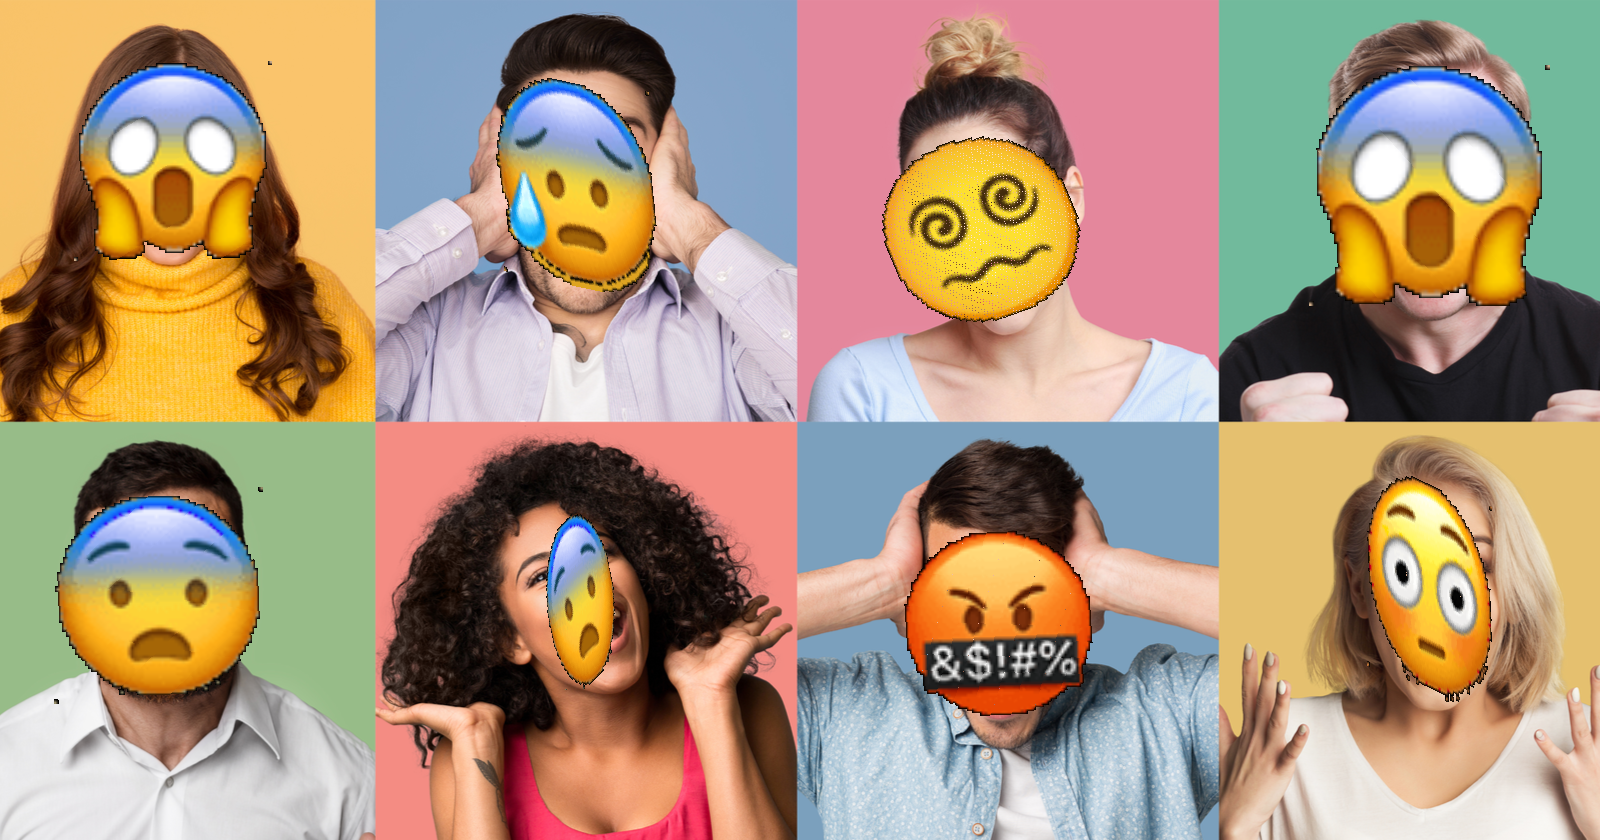

In [86]:
out = exp.run()

## Drafts (Ignore below)

In [46]:
a = 20 /180*np.pi         # alpha
b = 10 /180*np.pi         # beta
y = 45 /180*np.pi         # gamma

In [250]:
R = np.array([
    [np.cos(a)*np.cos(b), np.cos(a)*np.sin(b)*np.sin(y)-np.sin(a)*np.cos(y), np.cos(a)*np.sin(b)*np.cos(y)+np.sin(a)*np.sin(y)],
    [np.sin(a)*np.cos(b), np.sin(a)*np.sin(b)*np.sin(y)+np.cos(a)*np.cos(y), np.sin(a)*np.sin(b)*np.cos(y)-np.cos(a)*np.sin(y)],
    [-np.sin(b), np.cos(b)*np.sin(y), np.cos(b)*np.cos(y)]
])

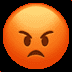

In [325]:
emoji = cv2.imread("./emoji/anger/93.png")
emoji = np.where(emoji!=np.array([76, 112, 71]), emoji, np.zeros(3)).astype(np.uint8)
display(Image.fromarray(emoji[:,:,::-1]))

In [326]:
def coord_transform(img):
    new_img = np.zeros_like(img)
    h, w, _ = img.shape
    r = max(h, w)/2
    for i in range(h):
        for j in range(w):
            original_coord = np.array([j-r, r-i, 0])
            new_coord = np.dot(R, original_coord)
            new_x = min(int(new_coord[0] + r), 71)
            new_y = int(r - new_coord[1])
            print(new_x, new_y)
            new_img[new_y][new_x] = img[i][j].copy()
        
    return new_img

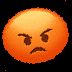

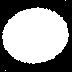

In [327]:
new_emoji = coord_transform(emoji)
mask = np.ones_like(new_emoji)*255
mask = np.where(new_emoji!=np.zeros(3), mask, np.zeros(3)).astype(np.uint8)
display(Image.fromarray(new_emoji[:,:,::-1]))
display(Image.fromarray(mask[:,:,::-1]))

In [179]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

In [171]:
import dlib

In [214]:
predictor_path = "./weights/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector() #Call the face detector. Only the face is detected.
predictor = dlib.shape_predictor(predictor_path) # Output landmarks such as eyes and nose from the face

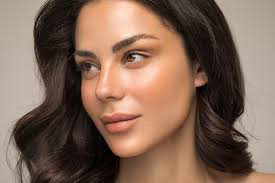

In [260]:
image = cv2.imread("./img/side.jpeg")
display(Image.fromarray(image[:,:,::-1]))

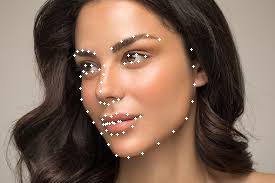

In [261]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Convert to gray scale
rects = detector(gray, 0) #Detect face from gray
image_points = None

for rect in rects:
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)

    for (x, y) in shape: #Plot 68 landmarks on the entire face
        cv2.circle(image, (x, y), 1, (255, 255, 255), -1)
        
display(Image.fromarray(image[:,:,::-1]))